#### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import wrangle
import prepare
import explore
import evaluate

# Exercises

#### Notes

$^1$
 Regularization = "Regularizations are techniques used to reduce the error by fitting a function appropriately on the given training set and avoid overfitting." Towards Data Science

$^2$
 TweedieRegressor: Requires sklearn v0.23 or greater installed. To update, run in terminal: conda install scikit-learn=0.23

#### 1. Select a dataset with a continuous target variable.



In [2]:
df = wrangle.get_zillow_data()

Found CSV


In [3]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


#### 2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.



In [4]:
df = wrangle.wrangle_zillow(df)

In [5]:
df.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,county,orange,ventura
4,4,2.0,3633,296425,2005,6941.39,la,0,0
6,3,4.0,1620,847770,2011,10244.94,la,0,0
7,3,2.0,2077,646760,1926,7924.68,la,0,0
18,3,1.0,1244,169471,1950,2532.88,la,0,0
19,3,2.0,1300,233266,1950,3110.99,la,0,0


In [6]:
train, validate, test = wrangle.split_function(df)

In [7]:
print(f'      df:', df.shape)
print(f'   train:', train.shape)
print(f'validate:', validate.shape)
print(f'    test:', test.shape)

      df: (2010708, 9)
   train: (1206424, 9)
validate: (402142, 9)
    test: (402142, 9)


In [8]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,county,orange,ventura
1752514,3,1.5,1179,159188,1957,2022.20,orange,1,0
1400740,3,2.0,1663,456862,1952,5603.99,la,0,0
1278943,3,2.0,1133,208719,1963,2514.38,orange,1,0
1105547,3,3.0,2562,555988,1969,6375.61,la,0,0
355207,4,2.0,2747,673720,1935,8411.60,la,0,0


#### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.



Split into X_train, y_train ....

In [9]:
to_scale = ['bedrooms', 'bathrooms', 'sqft', 'year_built', 'orange', 'ventura']

In [10]:
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test, to_scale)

In [11]:
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.Xy_train_val_test(train_scaled,
                                                                                     validate_scaled,
                                                                                     test_scaled,
                                                                                     'tax_value',
                                                                                     'tax_amount')

Baseline Accuracy: 358552.1404075184


In [12]:
X_train.head()

,bedrooms,bathrooms,sqft,year_built,orange,ventura
1752514,0.333333,0.1,0.119986,0.725581,1.0,0.0
1400740,0.333333,0.2,0.205513,0.702326,0.0,0.0
1278943,0.333333,0.2,0.111857,0.753488,1.0,0.0
1105547,0.333333,0.4,0.364375,0.781395,0.0,0.0
355207,0.500000,0.2,0.397067,0.623256,0.0,0.0


In [13]:
y_train[:5]

1752514    159188
1400740    456862
1278943    208719
1105547    555988
355207     673720
Name: tax_value, dtype: int64

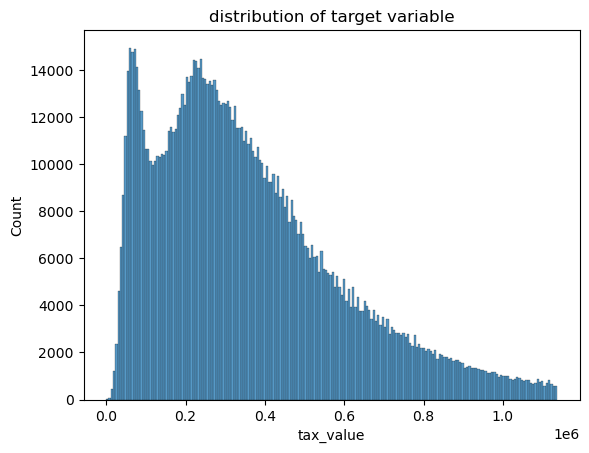

In [15]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

### Baseline

In [18]:
baseline = y_train.mean()
baseline

358552.1404075184

#### Evaluate

In [19]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [21]:
baseline_array = np.repeat(baseline, len(train))
baseline_array

array([358552.14040752, 358552.14040752, 358552.14040752, ...,
       358552.14040752, 358552.14040752, 358552.14040752])

In [23]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(235115.83647164318, 0.0)

In [24]:
metrics_df = pd.DataFrame(data=[
    {
        'model': 'baseline',
        'rmse': rmse,
        'r2': r2 
    }
])
metrics_df

,model,rmse,r2
0,baseline,235115.836472,0.0


## Ordinary Least Squares (OLS)

In [25]:
from sklearn.linear_model import LinearRegression

#### simple linear regression + RFE

In [26]:
from sklearn.feature_selection import RFE

In [47]:
# initial ML model
lr1 = LinearRegression()

# make it
rfe = RFE(lr1, n_features_to_select=1)

# fit it
rfe.fit(X_train, y_train)

# use it on train
X_train_rfe = rfe.transform(X_train)

# use it on validate
X_validate_rfe = rfe.transform(X_validate)

In [48]:
print('Select top feature:', rfe.get_feature_names_out())

Select top feature: ['sqft']


In [59]:
y_train

1752514    159188
1400740    456862
1278943    208719
1105547    555988
355207     673720
            ...  
1022529    628776
360193     598996
1443844    446552
519116     105685
1117592     68843
Name: tax_value, Length: 1206424, dtype: int64

#### Build model from top feature

In [49]:
# fit it
lr1.fit(X_train_rfe, y_train)

# use it (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_validate_lr1 = lr1.predict(X_validate_rfe)

In [50]:
pred_lr1[:5]

array([260873.47904915, 344666.7459739 , 252909.65615961, 500307.54548908,
       532335.96363181])

#### evaluate

In [51]:
# train
metrics_reg(y_train, pred_lr1)

(201626.23726162603, 0.2645886540448711)

In [52]:
# validate
rmse, r2 = metrics_reg(y_validate, pred_validate_lr1)
rmse, r2

(201914.61493214258, 0.26290837875969864)

In [53]:
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,235115.836472,0.000000
1,ols_1,201914.614932,0.262908


In [60]:
y_train.min(), y_train.max()

(22, 1136369)

#### Examine the model

In [54]:
lr1.intercept_

143320.52813612187

In [40]:
lr1.coef_

array([979723.34199825])

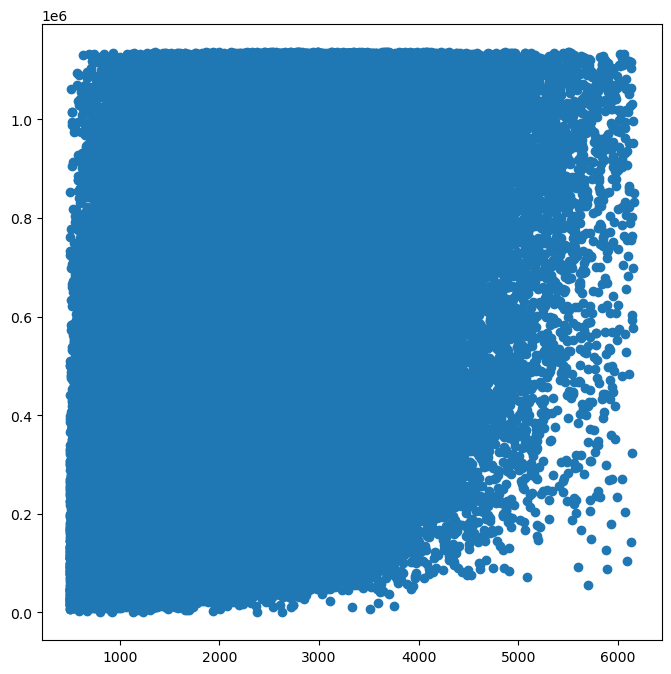

In [66]:
plt.figure(figsize=(8,8))

plt.scatter(train.sqft, train.tax_value)

plt.show()

#### Multiple Regression

In [68]:
# make it
lr2 = LinearRegression()

# fit it on our RFE features
lr2.fit(X_train, y_train)

# use it (make predictions)
pred_lr2 = lr2.predict(X_train)

# use it on validate
pred_validate_lr2 = lr2.predict(X_validate)

In [69]:
pred_lr2[:5]

array([284311.16784825, 336554.61261473, 294937.37593547, 520584.33490568,
       472147.11405245])

#### evaluate

In [70]:
metrics_reg(y_train, pred_lr2)

(198947.33198818425, 0.284000904342676)

In [71]:
rmse, r2 = metrics_reg(y_validate, pred_validate_lr2)
rmse, r2

(199238.77247683494, 0.2823153145144327)

In [72]:
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,235115.836472,0.000000
1,ols_1,201914.614932,0.262908
2,ols,199238.772477,0.282315


## LassoLars

In [73]:
from sklearn.linear_model import LassoLars

In [79]:
# make it
lars = LassoLars(alpha=1, normalize=False)

# fit it
lars.fit(X_train, y_train)

# use it
pred_lars = lars.predict(X_train)
pred_validate_lars = lars.predict(X_validate)

In [77]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

bedrooms     -223984.031412
bathrooms     167645.213644
sqft          922914.133795
year_built     48762.362102
orange         42330.047698
ventura        17919.424460
dtype: float64

#### evaluate

In [78]:
metrics_reg(y_train, pred_lars)

(198947.33295151315, 0.2840008974087542)

In [80]:
rmse, r2 = metrics_reg(y_validate, pred_validate_lars)
rmse, r2

(199238.74123172948, 0.2823155396125061)

In [82]:
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,235115.836472,0.000000
1,ols_1,201914.614932,0.262908
2,ols,199238.772477,0.282315
3,lars,199238.741232,0.282316


#### Polynomial Regression

In [83]:
from sklearn.preprocessing import PolynomialFeatures

In [84]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

#### fit on a linear regression model

In [85]:
# make it
pr = LinearRegression()

# fit it
pr.fit(X_train_degree2, y_train)

# use it
pred_pr = pr.predict(X_train_degree2)
pred_validate_pr = pr.predict(X_validate_degree2)

#### evaluate

In [86]:
metrics_reg(y_train, pred_pr)

(195827.6096321643, 0.3062802154577926)

In [87]:
rmse, r2 = metrics_reg(y_validate, pred_validate_pr)
rmse, r2

(196173.64476730413, 0.30422745693606)

In [89]:
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,235115.836472,0.000000
1,ols_1,201914.614932,0.262908
2,ols,199238.772477,0.282315
3,lars,199238.741232,0.282316
4,poly_2,196173.644767,0.304227


### Generalized Linear Model (GLM)

In [90]:
from sklearn.linear_model import TweedieRegressor

In [91]:
# make it
glm = TweedieRegressor(power=1, alpha=0)

# fit it
glm.fit(X_train, y_train)

# use it 
pred_glm = glm.predict(X_train)
pred_validate_glm = glm.predict(X_validate)

#### Evaluate

In [92]:
metrics_reg(y_train, pred_glm)

(200971.31417988316, 0.2693584264974487)

In [93]:
rmse, r2 = metrics_reg(y_validate, pred_validate_glm)
rmse, r2

(201244.872525851, 0.26779007381522246)

In [95]:
metrics_df.loc[5] = ['glm', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,235115.836472,0.000000
1,ols_1,201914.614932,0.262908
2,ols,199238.772477,0.282315
3,lars,199238.741232,0.282316
4,poly_2,196173.644767,0.304227
5,glm,201244.872526,0.267790


In [96]:
pred_test = pr.predict(X_test_degree2)
pred_test

array([568267.25926971, 254414.28466034, 360477.81373596, ...,
       250523.36307526, 470397.5369339 , 394828.95372009])

In [98]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(195642.27339333645, 0.30601829950539816)

#### Plot actuals vs predicted

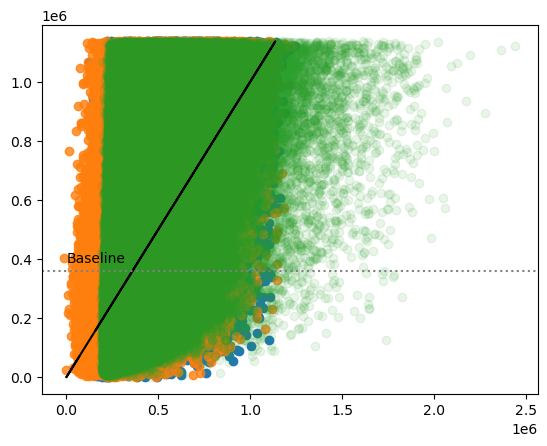

In [114]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='ploynominal 2 deg', alpha=.8)
plt.scatter(pred_glm, y_train, label='glm', alpha=.1)
plt.plot(y_train, y_train, label='_nolegend_', color='black')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate('Baseline', (0, 390_000))

plt.show()

#### Plotting the residuals

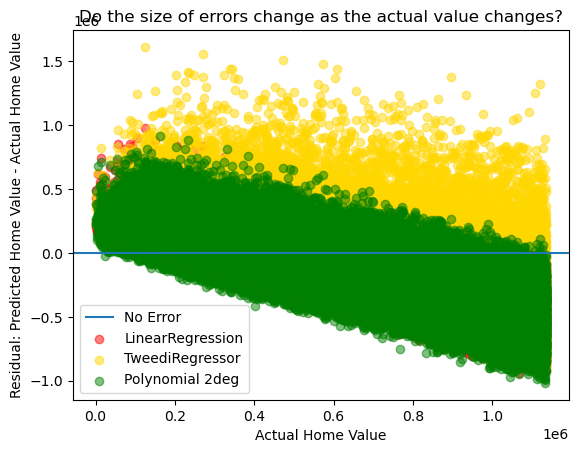

In [116]:
plt.axhline(label='No Error')

plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color='red', label='LinearRegression')
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color='gold', label='TweediRegressor')
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color='green', label='Polynomial 2deg')

plt.legend()
plt.title('Do the size of errors change as the actual value changes?')
plt.xlabel('Actual Home Value')
plt.ylabel('Residual: Predicted Home Value - Actual Home Value')

plt.show()

#### Histogram of actual and predicted values

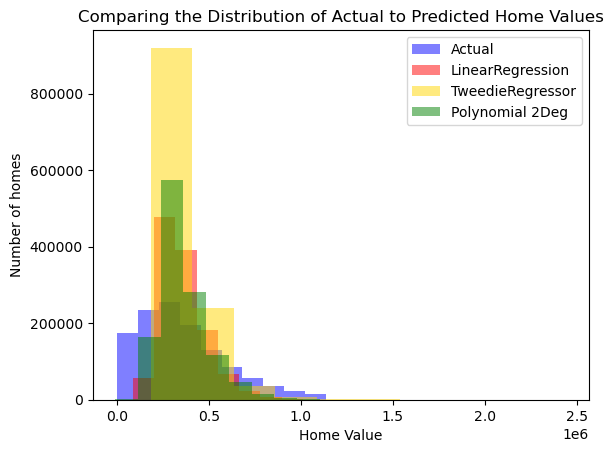

In [117]:
plt.hist(y_train, color='blue', alpha=.5, label='Actual')
plt.hist(pred_lr2, color='red', alpha=.5, label='LinearRegression')
plt.hist(pred_glm, color='gold', alpha=.5, label='TweedieRegressor')
plt.hist(pred_pr, color='green', alpha=.5, label='Polynomial 2Deg')

plt.xlabel("Home Value")
plt.ylabel("Number of homes")
plt.title("Comparing the Distribution of Actual to Predicted Home Values")
plt.legend()
plt.show()